In [23]:
import os
import sys
sys.path.append('../ideepcolor')
from data import colorize_image as CI
import autocolorize
import caffe
import skimage.io
import skimage.color
from skimage import img_as_float
import matplotlib.pyplot as plt
import numpy as np
import segment
import prepare_data

%matplotlib inline

In [21]:
orig_img_prefix = '../img/original/'
bw_img_prefix = '../img/bw/'
auto_img_prefix = '../img/auto/'
res_img_prefix = '../img/result/'
user_img_prefix = '../img/user/'
seg_img_prefix = '../img/segment/'

img_urls = prepare_data.generate_bw_images_and_list()

In [3]:
def loadAutoModel():
    caffe.set_mode_cpu()
    classifier = autocolorize.load_default_classifier()
    return classifier

In [4]:
def loadUserModel():
    os.chdir('../ideepcolor')
    gpu_id = -1 # cpu
    colorModel = CI.ColorizeImageCaffe(Xd=256)
    colorModel.prep_net(gpu_id,'./models/reference_model/deploy_nodist.prototxt','./models/reference_model/model.caffemodel')
    os.chdir('../src')
    return colorModel

In [5]:
# Does not return anything, just writes the colored image
def auto_colorize(img_url, model):
    gray = img_as_float(skimage.io.imread(bw_img_prefix + img_url, as_grey=True))
    rgb = autocolorize.colorize(gray, classifier=model)
    skimage.io.imsave(auto_img_prefix + img_url, rgb)

In [6]:
# returns a list of ((r,c), (L,a,b)) tuples for (row, col) points to color in LAB space
# r and c are in [0, 1)
def get_color_points(img_url):
    return segment.get_color_points(img_url)

In [7]:
# Does not return anything, writes the final result
def user_driven_color(img_url, model, points):
    model.load_image(bw_img_prefix + img_url) 
    mask = np.zeros((1,256,256))
    input_ab = np.zeros((2,256,256))
    
    # user-driven without input points
    img_out = model.net_forward(input_ab, mask)
    img_out_fullres = model.get_img_fullres()
    skimage.io.imsave(user_img_prefix + img_url, img_out_fullres)
    
    for ((r, c), (L, a, b)) in points:
        r = int(r*256)
        c = int(c*256)
        mask[0, r, c] = 1
        input_ab[0, r, c] = a
        input_ab[1, r, c] = b
    
    # user-driven with input points (final result)
    img_out = model.net_forward(input_ab, mask)
    img_out_fullres = model.get_img_fullres()
    skimage.io.imsave(res_img_prefix + img_url, img_out_fullres)

In [8]:
autoModel = loadAutoModel()
userModel = loadUserModel()

Loading /home/ubuntu/.autocolorize/autocolorize.caffemodel.h5
ColorizeImageCaffe instantiated
gpu_id = -1, net_path = ./models/reference_model/deploy_nodist.prototxt, model_path = ./models/reference_model/model.caffemodel


In [9]:
for img_url in img_urls:
    auto_colorize(img_url, autoModel)
    points = get_color_points(img_url)
    user_driven_color(img_url, userModel, points)

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [29]:
def show_images(img_url):
    auto_image = skimage.io.imread(auto_img_prefix+img_url)
    user_image = skimage.io.imread(user_img_prefix+img_url)
    res_image = skimage.io.imread(res_img_prefix+img_url)
    #bw_image = skimage.color.gray2rgb(skimage.io.imread(bw_img_prefix+img_url))
    seg_image = skimage.io.imread(seg_img_prefix+img_url)
    orig_image = skimage.io.imread(orig_img_prefix+img_url)
    plt.imshow(np.concatenate((auto_image, user_image, res_image, seg_image, orig_image), axis=1))

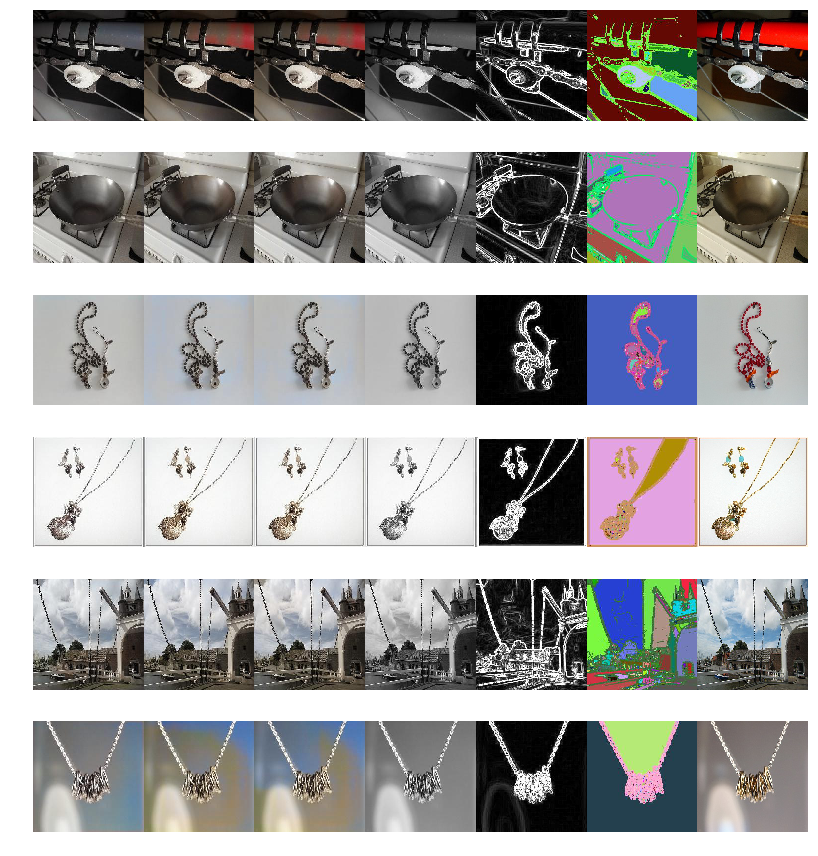

In [36]:
plt.figure(figsize=(12, 2*len(img_urls)))
for index, img_url in enumerate(img_urls):
    plt.subplot(len(img_urls), 1, index+1)
    show_images(img_url)
    plt.axis('off')